Adapted by Tias Guns <Tias.Guns@kuleuven.be>, based (very heavily) on:

# Handwritten Digit Recognition
- Author = Amitrajit Bose
- Dataset = MNIST
- [Medium Article Link](https://medium.com/@amitrajit_bose/handwritten-digit-mnist-pytorch-977b5338e627)
- Frameworks = PyTorch

The first 3 boxes are identical to the p0 notebook; then it starts...

### Necessary Imports

Recommended installation instructions:
https://pytorch.org/get-started/locally

This typically involves installing python3, python3-numpy, python3-matplotlib through an installer (anaconda) or system manager (apt), then installing torch and torchvision from python through conda or pip.

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

### Download The Dataset & Define The Transforms

It is best to do this before the practical; + it allows you to test whether your setup works!

It will download the files into the __same directory as where you stored this notebook__.

It will take a minute or two. It will only download it once, so you can rerun this cell over and over.

In [4]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('.', download=True, train=True, transform=transform)
testset = datasets.MNIST('.', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
print("Data loaded.")

Data loaded.


### Showing a grid

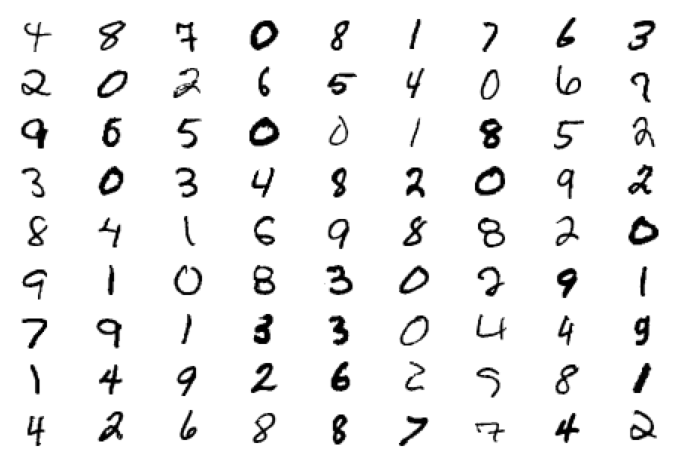

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

dim = 9
figure = plt.figure()
num_of_images = dim*dim
for index in range(1, num_of_images + 1):
    plt.subplot(dim, dim, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining The Neural Network

We will now define the __architecture__ of the neural network.

We define two architectures: a standard multi-layer perceptron network (the classical MLP) and a famous vision-specific architecture which is known to do well on MNIST: the LeNet architecture.

Building an architecture is done _declaratively_ in pytorch, very elegant as you will see.

### MLP architecture:
(this is the standard fully connected used since the 80's network)

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [6]:
from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network, declaratively
def MLP():
    return nn.Sequential(nn.Flatten(), # Flatten MNIST images into a 784 long vector
                         nn.Linear(input_size, hidden_sizes[0]),
                         nn.ReLU(),
                         nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                         nn.ReLU(),
                         nn.Linear(hidden_sizes[1], output_size),
                         nn.LogSoftmax(dim=1))
print(MLP())

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): LogSoftmax()
)


### LeNet architecture

We now built a LeNet architecture, introduced by Yann LeCun in 1998. It consists of a convolutional layere followed by max-pooling, again a convolutional layer followed by max pooling, and then two fully connected layer followed by the LogSoftMax() output layer.

The image below shows a graphical representation of the network, and for a given input image what the output of each layer is.

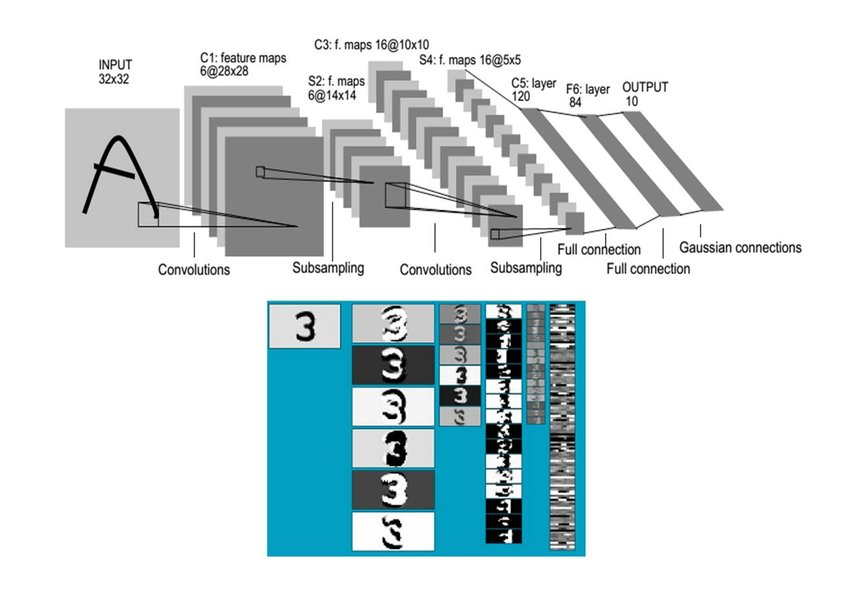

_Good to know:_ the convolutions are copied a number of times, each copy creates its own 'channel' (you can think of it as a third dimension) hence the multiple versions.

We build the LeNet similarly but as a new class instead.
__@Team: can any of you make the network dimensions match the image, and perhaps rewrite the below in the style of the above?? (using Sequential) thx!__


In [7]:
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, calibrated=False):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*16) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

print(LeNet())

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Core Training Of Neural Network

Training is through stochastic gradient descent, with a given learning rate (lr) and momentum. Together with the number of epochs, the number of passes over the data, these determine the _hyperparameters_.

In [10]:
from torch import optim

def train_model(model, optimizer, epochs):
    # the stochastic gradient descent loop
    criterion = nn.NLLLoss() # negative log likelihood as loss
    time0 = time()
    print("Training starts, using", len(trainset), "training instances...")
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
    
            # Training pass
            optimizer.zero_grad()
        
            output = model(images)
            loss = criterion(output, labels)
        
            #This is where the model learns by backpropagating
            loss.backward()
        
            #And optimizes its weights here
            optimizer.step()
        
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    return model


# hyperparameters
model = MLP()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 2

train_model(model, optimizer, epochs)

Training starts, using 60000 training instances...
Epoch 0 - Training loss: 0.8890696398929746
Epoch 1 - Training loss: 0.3455578404893753

Training Time (in minutes) = 0.23330774307250976


Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): LogSoftmax()
)

## Visualising the output

We use a helper function and then show both the input image, its output probability distribution and the maximum likelihood prediction.

In [11]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 9


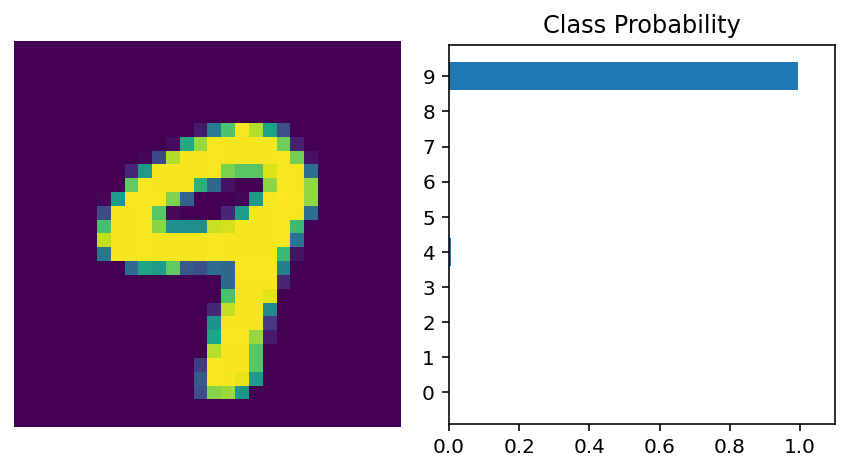

In [12]:
def show_one_prediction(images, labels, i=0):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    view_classify(img.view(1, 28, 28), ps)
    print("Predicted Digit =", probab.index(max(probab)))

images, labels = next(iter(testloader))
show_one_prediction(images, labels)

You may notice a wrong prediction and varying class probabilities. That's because the network has _high training error_, measured by the training loss.

__Task for you__: Adjust the hyperparameters (and your patience) to train a better model!

### Model Evaluation

Manually and visually inspecting a few predictions is good practice, but to know how good your model is you need a proper evaluation.

The _loss_ computes the negative loglikelihood of the predicted _probabilities_. The code below computes the _accuracy_ of the actualy predicted class (not its probability):

In [13]:
def eval_model(model, testloader):
    # returns (all_count, correct_count, all_loss)
    correct_count, all_count = 0, 0
    all_loss = 0.0
    
    criterion = nn.NLLLoss() # negative log likelihood as loss
    with torch.no_grad(): # Turn off gradients to speed up this part
        for images,labels in testloader:
            all_loss += criterion(model(images.view(images.shape[0], -1)),labels)
  
            for i in range(len(labels)):
                img = images[i].view(1, 784)
                logps = model(img)
    
            # Output of the network are log-probabilities, need to take exponential for probabilities
            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1
    return (all_count, correct_count, all_loss)

(all_count, correct_count, all_loss) = eval_model(model, testloader)
print("Number Of Images Tested =", all_count)
print("\tAvg test loss =", float(all_loss/all_count))
print("\tTest accuracy =", (correct_count/all_count)*100,"%")

Number Of Images Tested = 79
	Avg test loss = 0.2977162301540375
	Test accuracy = 83.54430379746836 %


## Visual sudoku time!

We will use your trained classifier to predict the output of a 'visual sudoku'. You will then use those predictions to solve the sudoku.

For __solving the sudoku's__, I recommend:
  * If you participated in the hackathon, use MiniCP
  * If you know how to model CP problems, use the python interface to _ortools_ (conda install ortools) https://developers.google.com/optimization/install/python
  * If you know very little of CP or want to get up-and-running quickly, use the python wrapper of _minizinc_ (conda install minizinc) https://pypi.org/project/minizinc/#getting-started
 
We use sudoku instances from the following link, see also that link for the minizinc model:
http://hakank.org/minizinc/sudoku_problems2/index.html

In [14]:
# sudoku's, from http://hakank.org/minizinc/sudoku_problems2/index.html

sudoku_p0 = np.array([[0,0,0, 2,0,5, 0,0,0],
                      [0,9,0, 0,0,0, 7,3,0],
                      [0,0,2, 0,0,9, 0,6,0],
                      [2,0,0, 0,0,0, 4,0,9],
                      [0,0,0, 0,7,0, 0,0,0],
                      [6,0,9, 0,0,0, 0,0,1],
                      [0,8,0, 4,0,0, 1,0,0],
                      [0,6,3, 0,0,0, 0,8,0],
                      [0,0,0, 6,0,8, 0,0,0]])
sudoku_p0

array([[0, 0, 0, 2, 0, 5, 0, 0, 0],
       [0, 9, 0, 0, 0, 0, 7, 3, 0],
       [0, 0, 2, 0, 0, 9, 0, 6, 0],
       [2, 0, 0, 0, 0, 0, 4, 0, 9],
       [0, 0, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 9, 0, 0, 0, 0, 0, 1],
       [0, 8, 0, 4, 0, 0, 1, 0, 0],
       [0, 6, 3, 0, 0, 0, 0, 8, 0],
       [0, 0, 0, 6, 0, 8, 0, 0, 0]])

In [15]:
def sample_visual_sudoku(sudoku_p, dataset):
    (img, lbl) = dataset
    print(lbl)
    
sample_visual_sudoku(sudoku_p0, trainset)

ValueError: too many values to unpack (expected 2)

In [14]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [15]:
len(trainset)

60000

In [16]:
trainset[0]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000